### About this demo

This demo shows the jets information of [`Top Quark Tagging` dataset](https://zenodo.org/records/2603256).

The information is presenting in graphs, plotted with `matplotlib.pyplot` and `seaborn`. This demo contains the following contents:
- Distribution of jets energy flow information $p_T$, $\eta$, $\phi$.
- Distribution of particles energy flow information $p_T$, $\eta$, $\phi$.

In [9]:
import os
import sys

import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sys.path.append(os.path.abspath('../'))

from source.data import opendata

sns.set_theme()

In [10]:
# Make sure raw root files exist.
channel_list = ['TOP', 'QCD']
fatjet_list = [
    opendata.TopQuarkEvents(mode='test', is_signal_new=1, pt_threshold=0.025).events, # Top
    opendata.TopQuarkEvents(mode='test', is_signal_new=0, pt_threshold=0.025).events, # QCD
]

### Distribution of fatjet $p_T$, $\eta$, $m$ and # of particles per jet.

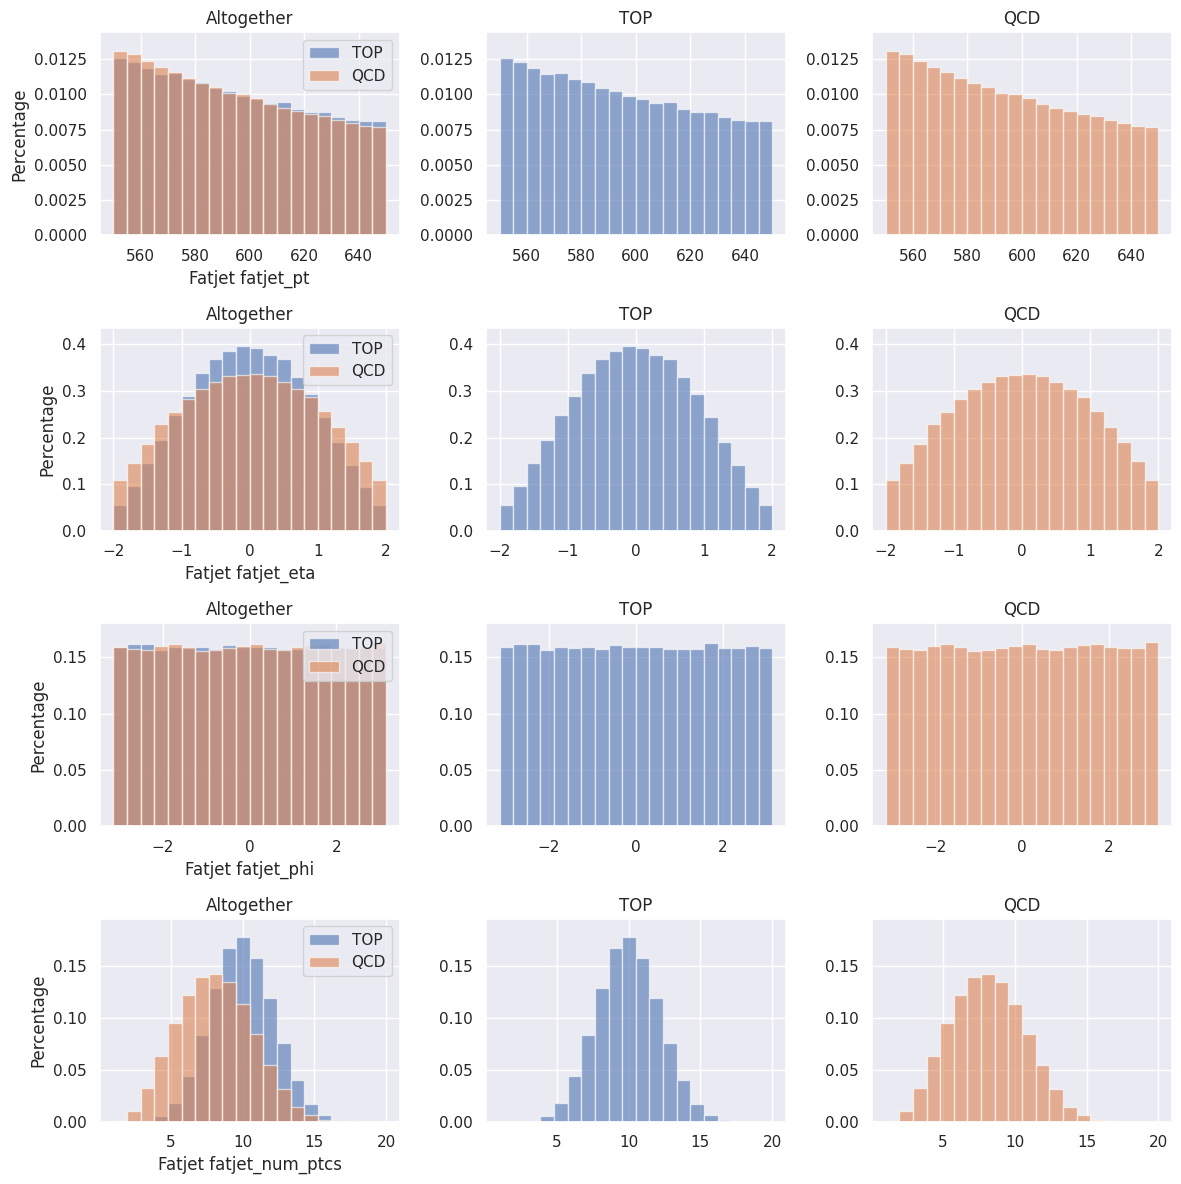

In [11]:
# Figure configurations.
num_row = 4 # Number of rows.
num_col = len(channel_list) + 1 # Number of columns, "+1" used for total.
width, height = 3 * (num_col + 1), 3 * num_row # Figure width and height.

# Create figures.
fig, ax = plt.subplots(num_row, num_col, figsize=(width, height))

def draw_jet_eflow_distribution(
        row_ax,
        feature: str,
        bins: int,
    ):
    """Draw distribution of jet energy flow information.
    
    Args:
        row_ax : Axes object
            One of the row of 2D axes object.
        feature : str
            The feature of jet to be drawed (pt, eta, or phi).
        bins : int
            Number of bins of the histogram.
    """
    
    # Will determine the range for y-axis depending on the feature values.
    yrange = [0,0]
    
    for i in range(len(channel_list)):
        # One of the channel events.
        events = fatjet_list[i]

        # Color for this channel.
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]

        # `plt` needs to convert `ak.Array` to `np.array`
        data = ak.to_numpy(events[feature])

        # The 0-th column plots the total overlapped histogram.
        pdf, _, _ = row_ax[0].hist(
            x=data,
            bins=bins,
            label=channel_list[i],
            alpha=0.6,
            density=True
        )

        # The (i+1)-th column plots the individual histogram.
        row_ax[i+1].hist(
            x=data,
            bins=bins,
            label=channel_list[i],
            alpha=0.6,
            density=True,
            color=color
        )

        # Update the values for y_range such that the scale for each channel is
        # the same.
        yrange[1] = max(yrange[1], max(pdf))
    
    # Rescale the `yrange` value a bit more higher.
    yrange[1] *= 1.1

    for i in range(len(channel_list)):
        # Altogether column.
        row_ax[0].set_title('Altogether')
        row_ax[0].set_xlabel(f"Fatjet {feature}")
        row_ax[0].set_ylabel('Percentage')
        row_ax[0].set_ylim(yrange)
        row_ax[0].legend()
        
        # Individual column.
        row_ax[i+1].set_title(channel_list[i])
        row_ax[i+1].set_ylim(yrange)

# Draw distribution.
draw_jet_eflow_distribution(ax[0], 'fatjet_pt', bins=20)
draw_jet_eflow_distribution(ax[1], 'fatjet_eta', bins=20)
draw_jet_eflow_distribution(ax[2], 'fatjet_phi', bins=20)
draw_jet_eflow_distribution(ax[3], 'fatjet_num_ptcs', bins=20)
plt.tight_layout()

### Distribution of jet (fatjet) daughter particle information

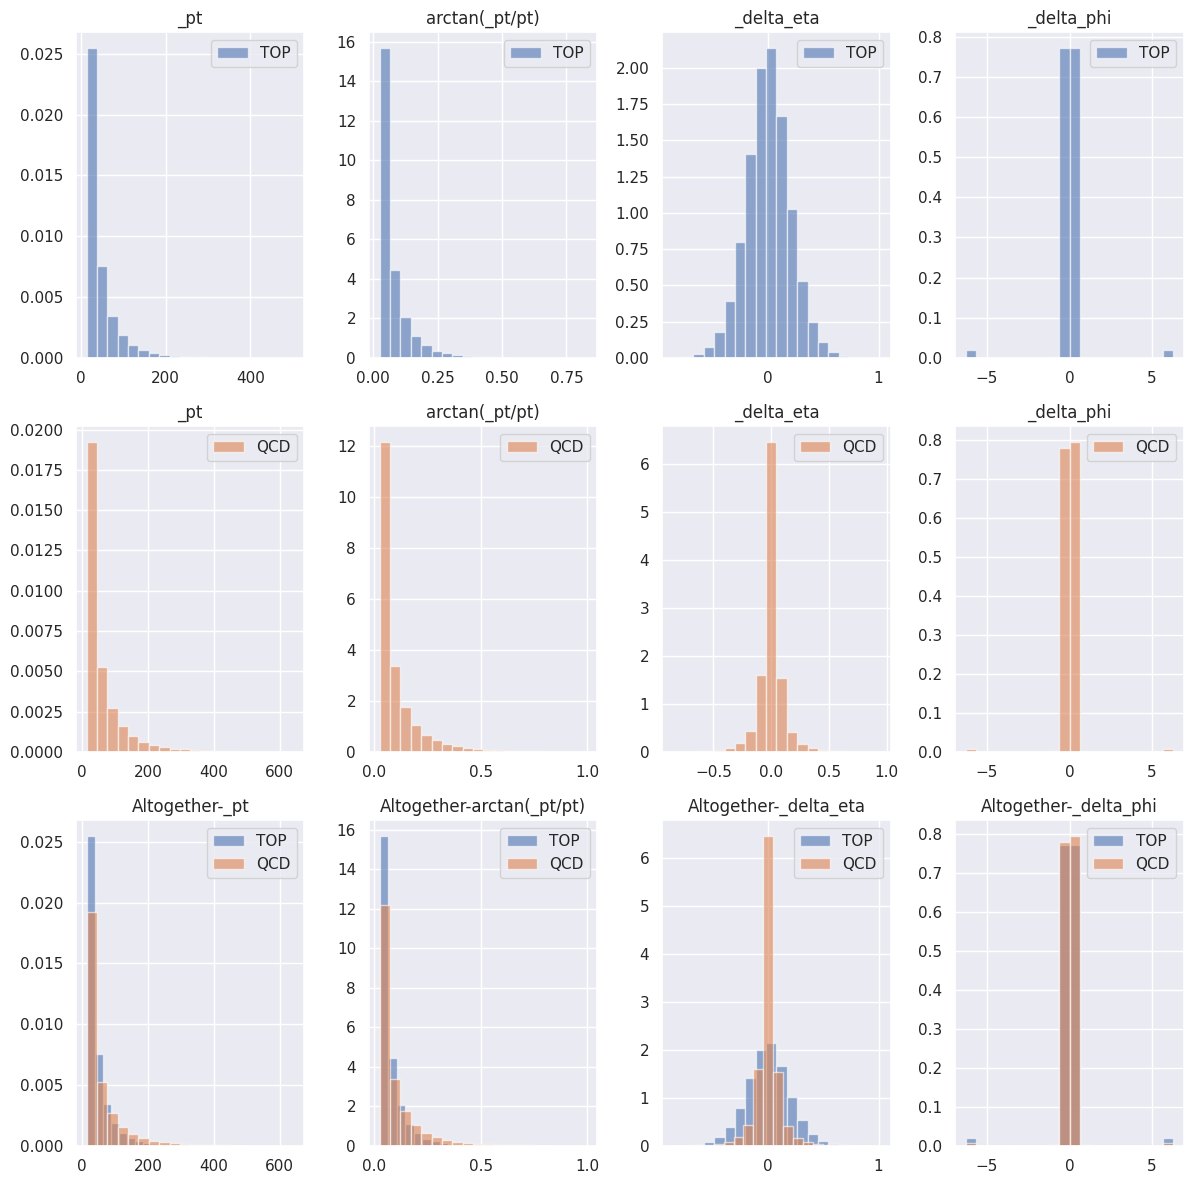

In [12]:
def draw_feature_hist(ax: plt.Axes, x: np.array, channel: str, color_idx: int):
    """Draw histogram of a particlue feature array (x)."""

    # Choose the same color for same row.
    color=plt.rcParams['axes.prop_cycle'].by_key()['color'][color_idx]

    # Plot histogram.
    ax.hist(
        x=x,
        bins=20,
        label=channel,
        range=None,
        alpha=0.6,
        density=True,
        color=color,
    )

def get_raveled_events(events: ak.Array):
    """Return raveled feature ak.Array dictionary."""
    
    jet_pt = events['fatjet_pt']
    daughter_pt = events['pt']
    delta_eta = events['delta_eta']
    delta_phi = events['delta_phi']
    # delta_phi = np.mod(delta_phi + np.pi, 2 * np.pi) - np.pi

    return {
        "_pt": ak.ravel(daughter_pt),
        "arctan(_pt/pt)": ak.ravel(daughter_pt / jet_pt),
        "_delta_eta": ak.ravel(delta_eta),
        "_delta_phi": ak.ravel(delta_phi),
    }

# Create raveled events for each fatjet event.
raveled_events_list = [get_raveled_events(fatjet) for fatjet in fatjet_list]

# Get feature keys of raveled events.
feature_keys = list(raveled_events_list[0].keys())

# Figure configurations.
num_row = len(channel_list) + 1 # Number of rows.
num_col = len(feature_keys) # Number of columns.
width = 3 * num_col # Figure width.
height = 3 * (num_row + 1) # Figure height.

# Create figures.
fig, ax = plt.subplots(num_row, num_col, figsize=(width, height))

for feature_idx in range(len(feature_keys)):
    feature = feature_keys[feature_idx]
    
    for channel_idx in range(len(channel_list)):
        feature_array = raveled_events_list[channel_idx][feature]
        feature_array = np.array(feature_array)

        # Individual figure for each channel.
        individual_ax = ax[channel_idx][feature_idx]
        draw_feature_hist(
            ax=individual_ax, 
            x=feature_array,
            channel=channel_list[channel_idx],
            color_idx=channel_idx
        )
        individual_ax.set_title(f"{feature}")
        individual_ax.legend()

        # Altogether in a figure.
        altogether_ax = ax[num_row-1][feature_idx]
        draw_feature_hist(
            ax=altogether_ax, 
            x=feature_array,
            channel=channel_list[channel_idx],
            color_idx=channel_idx
        )
        altogether_ax.set_title(f"Altogether-{feature}")
        altogether_ax.legend()

plt.tight_layout()